In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import pandas as pd
%cd "/content/gdrive/My Drive/thesis/Data"

#csv import labels

train_ACL_labels = np.array(pd.read_csv("train-acl.csv", header=None).iloc[:,1])
train_abnormal_labels = np.array(pd.read_csv("train-abnormal.csv", header=None).iloc[:,1])
train_meniscus_labels = np.array(pd.read_csv("train-meniscus.csv", header=None).iloc[:,1])

valid_ACL_labels = np.array(pd.read_csv("valid-acl.csv", header=None).iloc[:,1])
valid_abnormal_labels = np.array(pd.read_csv("valid-abnormal.csv", header=None).iloc[:,1])
valid_meniscus_labels = np.array(pd.read_csv("valid-meniscus.csv", header=None).iloc[:,1])

test_ACL_labels = np.array(pd.read_csv("test-acl.csv", header=None).iloc[:,1])
test_abnormal_labels = np.array(pd.read_csv("test-abnormal.csv", header=None).iloc[:,1])
test_meniscus_labels = np.array(pd.read_csv("test-meniscus.csv", header=None).iloc[:,1])

#data path
train_path = "/content/gdrive/My Drive/thesis/Data/train"
train_axial_path = "/content/gdrive/My Drive/thesis/Data/train/coronal"

counter = 5
for filename in os.listdir(train_axial_path):
  if counter > 0:
    file0 = np.load(train_axial_path + '/' + filename)
    variancelist = []
    for slice in range(file0.shape[0]):
      variancelist.append(np.var(file0[slice,:,:]))
    #print(file0)
    #print('max', np.amax(file0))
    #print('mean', np.mean(file0))
    #print(filename, 'file shape', file0.shape, 'max_var_index', variancelist.index(max(variancelist)), max(variancelist))
    counter = counter - 1

print("done!")

/content/gdrive/My Drive/thesis/Data
done!


In [0]:
# model.py

import torch
import torch.nn as nn

from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)

    # change this to adapt to different networks
    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        # make sure that gap returns size 256
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x

In [0]:
import argparse
import json
import numpy as np
import os
import torch
from datetime import datetime
from pathlib import Path
from sklearn import metrics

def train(rundir, diagnosis, orientation, epochs, learning_rate, transformbool, use_gpu):
    
    val_auc_array = list()
    train_auc_array = list()
    test_auc_array = list()
    train_loader, valid_loader, test_loader = load_data(diagnosis, orientation, transformbool, use_gpu)
    
    model = MRNet()

    if use_gpu:
        model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=.01)

    # patience too low (after 5 epochs, if AUC hasnt improved, slash learning rate .3), which is why high learning rate seems to work better
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=.3, threshold=1e-4)

    best_val_loss = float('inf')

    start_time = datetime.now()

    for epoch in range(epochs):
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
        train_loss, train_auc, _, _ = run_model(model, train_loader, train=True, optimizer=optimizer)
        #print(f'train loss: {train_loss:0.4f}')
        #print(f'train AUC: {train_auc:0.4f}')

        val_loss, val_auc, _, _ = run_model(model, valid_loader)
        #print(f'valid loss: {val_loss:0.4f}')
        #print(f'valid AUC: {val_auc:0.4f}')

        test_loss, test_auc, _, _ = run_model(model, test_loader)

        val_auc_array.append(val_auc)
        train_auc_array.append(train_auc)
        test_auc_array.append(test_auc)
        
        scheduler.step(val_loss)

        """
        if val_loss < best_val_loss:
            best_val_loss = val_loss

            file_name = f'val{val_loss:0.4f}_train{train_loss:0.4f}_epoch{epoch+1}'
            save_path = Path(rundir) / file_name

            # dont need to save stuff for now, model is too shitty
            #torch.save(model.state_dict(), save_path)
            #if epoch == (epochs-1):
            #  print('model saved at', str(save_path))
            #  torch.save(model.state_dict(), save_path)
        """
    return val_auc_array, train_auc_array, test_auc_array

In [5]:
# loader.py

!pip install medicaltorch

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        """
        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)
        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]
        """

        train_string = "/content/gdrive/My Drive/thesis/Data/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        #print('paths', self.paths)
        path = self.paths[index]

        # with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
        #    vol = pickle.load(file_handler).astype(np.int32)
        
        vol = np.load(path)

        """
        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        #print('pad', pad)
        vol = vol[:,pad:-pad,pad:-pad]
        #vol = vol[pad:-pad,pad:-pad,:]
  
        # see if theres a way to reformat an image from 196 to 224 
        # something called interpolate, scikit image. 
        # consider scipy zoom too?


        problemflag = False

        if not(vol.shape[1] == 224) or not(vol.shape[2] == 224):
          #print('problem vol shape', vol.shape)
          delta_1 = (INPUT_DIM - vol.shape[1]) // 2
          delta_2 = (INPUT_DIM - vol.shape[2]) // 2
          padding = (delta_1, delta_2)
          new_vol = np.zeros((vol.shape[0], 224, 224), dtype=np.int32)
          for slice in range(vol.shape[0]):
            vol_slice = vol[slice,:,:]
            img_slice = PIL.Image.fromarray(vol_slice)
            new_vol[slice,:,:] = np.array(PIL.ImageOps.fit(img_slice, [224, 224]), dtype='i')
          vol = new_vol  
          vol.astype(np.int32)
          problemflag = True
          #print('vol shape', vol.shape)
          #print('vol type', vol.dtype)

        """
        #MEAN = np.mean(vol)
        #STDDEV = np.std(vol)

        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL
        vol = (vol - MEAN) / STDDEV

        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-30, 30)
        uni_noise = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          """
          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.8,1.2,256*256)
            noise_array.resize((256,256))
            
            vol = np.multiply(vol, noise_array)
            vol = np.clip(vol, 0, 255)
            vol = vol.astype(np.float32)
          """

            #randomangle = np.random.uniform(-20,20)
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomRotation((randomangle,randomangle), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/test"

    batchsize = 1
    numworkers = 4
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
# evaluate.py

import argparse
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

from sklearn import metrics
from torch.autograd import Variable

#from loader import load_data
#from model import MRNet

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_path', type=str, required=True)
    parser.add_argument('--split', type=str, required=True)
    parser.add_argument('--diagnosis', type=int, required=True)
    parser.add_argument('--gpu', action='store_true')
    return parser

def run_model(model, loader, train=False, optimizer=None):
    preds = []
    labels = []

    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.
    num_batches = 0

    for batch in loader:
        if train:
            optimizer.zero_grad()

        vol, label = batch
        if loader.dataset.use_gpu:
            vol = vol.cuda()
            label = label.cuda()
        vol = Variable(vol)
        label = Variable(label)

        logit = model.forward(vol)

        loss = loader.dataset.weighted_loss(logit, label)
        total_loss += loss.item()

        #
        pred = torch.sigmoid(logit)
        pred_npy = pred.data.cpu().numpy()[0][0]
        label_npy = label.data.cpu().numpy()[0][0]

        preds.append(pred_npy)
        labels.append(label_npy)

        if train:
            loss.backward()
            optimizer.step()
        num_batches += 1

    avg_loss = total_loss / num_batches

    fpr, tpr, threshold = metrics.roc_curve(labels, preds)
    auc = metrics.auc(fpr, tpr)

    return avg_loss, auc, preds, labels

def evaluate(split, model_path, diagnosis, orientation, use_gpu):
    train_loader, valid_loader, test_loader = load_data(diagnosis, orientation, transformbool, use_gpu)
    model = MRNet()
    state_dict = torch.load(model_path, map_location=(None if use_gpu else 'cpu'))
    model.load_state_dict(state_dict)

    if use_gpu:
        model = model.cuda()

    if split == 'train':
        loader = train_loader
    elif split == 'valid':
        loader = valid_loader
    elif split == 'test':
        loader = test_loader
    else:
        raise ValueError("split must be 'train', 'valid', or 'test'")

    loss, auc, preds, labels = run_model(model, loader)

    print(f'{split} loss: {loss:0.4f}')
    print(f'{split} AUC: {auc:0.4f}')

    return preds, labels

#if __name__ == '__main__':
#    args = get_parser().parse_args()
#   evaluate(args.split, args.model_path, args.diagnosis, args.gpu)

In [0]:
import matplotlib
matplotlib.use('Agg')
gpu = True
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

#learningrate = 5e-05
epochs = 100
#diagnosis = 'ACL'
rundir = "/content/gdrive/My Drive/thesis/Data"
#orientation = 'axial'
savedir = "/content/gdrive/My Drive/thesis/Results"


if gpu:
  torch.cuda.manual_seed_all(seed)

def display_single(x_length, lr1, varray, tarray, testarray, title, xlabel, ylabel, save_dir):
  plt.figure(0)
  plt.title(title)
  plt.plot(np.arange(x_length), varray, label='valid')
  plt.plot(np.arange(x_length), tarray, label='train')
  plt.plot(np.arange(x_length), testarray, label='test')
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.savefig(save_dir + '/' + title + '.eps', format='eps')
  plt.show()
  plt.close()
  return

In [0]:
#sag w/o aug
aug = False
epochs = 100
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet adam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



starting epoch 1. time passed: 0:00:00.000013
starting epoch 2. time passed: 0:03:24.281156
starting epoch 3. time passed: 0:04:19.466737


load_data meniscus coronal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.3230769230769231, 0.676923076923077]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


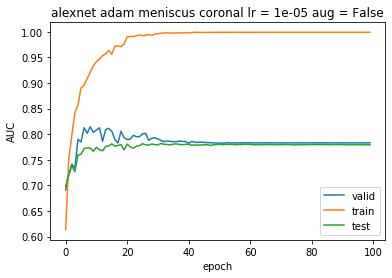

In [0]:
#cor w/o aug
aug = False
epochs = 100
diagnosis = 'meniscus'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet adam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data abnormal axial
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.812, 0.18799999999999994]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.7916666666666666, 0.20833333333333337]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.7769230769230769, 0.22307692307692306]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


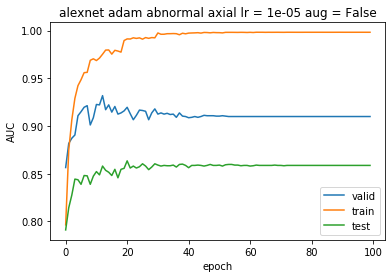

In [0]:
#ax w/o aug
aug = False
epochs = 100
diagnosis = 'abnormal'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet adam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

# NOW w/augmentation, NO NOISE

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


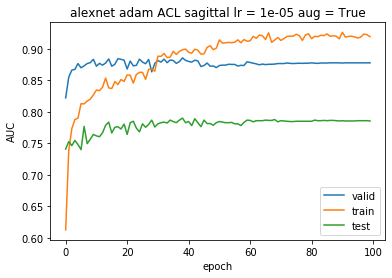

In [0]:
#sag w/ aug
aug = True
epochs = 100
diagnosis = 'ACL'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet adam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

In [0]:
#cor w/ aug
aug = True
epochs = 100
diagnosis = 'meniscus'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet adam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data meniscus coronal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.3230769230769231, 0.676923076923077]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:07<00:00, 34.0MB/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#ax w/ aug
aug = True
epochs = 100
diagnosis = 'abnormal'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet adam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data abnormal axial
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.812, 0.18799999999999994]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.7916666666666666, 0.20833333333333337]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.7769230769230769, 0.22307692307692306]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:01<00:00, 173MB/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ADD NOISE TO TRANSFORMATION POLICY

In [0]:
# loader.py

!pip install medicaltorch

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        """
        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)
        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]
        """

        train_string = "/content/gdrive/My Drive/thesis/Data/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        #print('paths', self.paths)
        path = self.paths[index]

        # with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
        #    vol = pickle.load(file_handler).astype(np.int32)
        
        vol = np.load(path)

        """
        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        #print('pad', pad)
        vol = vol[:,pad:-pad,pad:-pad]
        #vol = vol[pad:-pad,pad:-pad,:]
  
        # see if theres a way to reformat an image from 196 to 224 
        # something called interpolate, scikit image. 
        # consider scipy zoom too?


        problemflag = False

        if not(vol.shape[1] == 224) or not(vol.shape[2] == 224):
          #print('problem vol shape', vol.shape)
          delta_1 = (INPUT_DIM - vol.shape[1]) // 2
          delta_2 = (INPUT_DIM - vol.shape[2]) // 2
          padding = (delta_1, delta_2)
          new_vol = np.zeros((vol.shape[0], 224, 224), dtype=np.int32)
          for slice in range(vol.shape[0]):
            vol_slice = vol[slice,:,:]
            img_slice = PIL.Image.fromarray(vol_slice)
            new_vol[slice,:,:] = np.array(PIL.ImageOps.fit(img_slice, [224, 224]), dtype='i')
          vol = new_vol  
          vol.astype(np.int32)
          problemflag = True
          #print('vol shape', vol.shape)
          #print('vol type', vol.dtype)

        """
        #MEAN = np.mean(vol)
        #STDDEV = np.std(vol)

        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL
        vol = (vol - MEAN) / STDDEV

        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-30, 30)
        uni_noise = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.95,1.05,256*256)
            noise_array.resize((256,256))
            
            for sliceindex in range(vol.shape[0]):
              vol[sliceindex] = np.multiply(vol[sliceindex], noise_array)
              vol[sliceindex] = np.clip(vol[sliceindex], 0, 255)
            vol = vol.astype(np.float32)

            #randomangle = np.random.uniform(-20,20)
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomRotation((randomangle,randomangle), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/test"

    batchsize = 1
    numworkers = 4
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
#sag w/ aug
aug = True
epochs = 100
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet adam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:13<00:00, 18.7MB/s]


starting epoch 1. time passed: 0:00:00.000012
starting epoch 2. time passed: 0:03:11.767365
starting epoch 3. time passed: 0:04:56.755396
starting epoch 4. time passed: 0:06:39.974385
starting epoch 5. time passed: 0:08:22.664290
starting epoch 6. time passed: 0:10:04.901926
starting epoch 7. time passed: 0:11:46.928587
starting epoch 8. time passed: 0:13:27.463554
starting epoch 9. time passed: 0:15:08.500947
starting epoch 10. time passed: 0:16:48.162514
starting epoch 11. time passed: 0:18:27.561812
starting epoch 12. time passed: 0:20:07.293625
starting epoch 13. time passed: 0:21:46.257810
starting epoch 14. time passed: 0:23:25.580877
starting epoch 15. time passed: 0:25:04.526201
starting epoch 16. time passed: 0:26:43.276800
starting epoch 17. time passed: 0:28:22.446349
starting epoch 18. time passed: 0:30:03.166128
starting epoch 19. time passed: 0:31:46.050198
starting epoch 20. time passed: 0:33:25.442285
starting epoch 21. time passed: 0:35:05.254784
starting epoch 22. tim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#cor w/ aug
aug = True
epochs = 100
diagnosis = 'meniscus'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet adam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

load_data meniscus coronal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.3230769230769231, 0.676923076923077]
starting epoch 1. time passed: 0:00:00.000011
starting epoch 2. time passed: 0:03:19.720205
starting epoch 3. time passed: 0:05:05.150878
starting epoch 4. time passed: 0:06:45.976709
starting epoch 5. time passed: 0:08:27.966848
starting epoch 6. time passed: 0:10:10.290772
starting epoch 7. time passed: 0:11:53.703555
starting epoch 8. time passed: 0:13:35.496343
starting epoch 9. time passed: 0:15:17.186898
starting epoch 10. time passed: 0:17:00.854860
starting epoch 11. time passed: 0:18:41.367856
starting epoch 12. time passed: 0:20:20.384556
starting epoch 13. time passed: 0:21:58.628439
starting epoch 14. time passed: 0:23:36.617223
starting epoch 15. time passed: 0:25:14.581870
starting epoch 16. time passed

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#ax w/ aug
aug = True
epochs = 100
diagnosis = 'abnormal'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet adam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

load_data abnormal axial
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.812, 0.18799999999999994]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.7916666666666666, 0.20833333333333337]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.7769230769230769, 0.22307692307692306]
starting epoch 1. time passed: 0:00:00.000013
starting epoch 2. time passed: 0:03:07.880016
starting epoch 3. time passed: 0:05:06.831031
starting epoch 4. time passed: 0:06:59.762063
starting epoch 5. time passed: 0:08:57.526430
starting epoch 6. time passed: 0:10:53.901778
starting epoch 7. time passed: 0:12:47.371527
starting epoch 8. time passed: 0:14:39.663039
starting epoch 9. time passed: 0:16:31.445837
starting epoch 10. time passed: 0:18:23.261685
starting epoch 11. time passed: 0:20:15.036282
starting epoch 12. time passed: 0:22:09.800639
starting epoch 13. time passed: 0:24:03.648081
starting epoch 14. time passed: 0:25:56.725530
starting epoch 15. time passed: 0:27:50.307101
starting epoch 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


REMOVE NOISE AND R ADAM

In [0]:
# loader.py

!pip install medicaltorch

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        """
        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)
        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]
        """

        train_string = "/content/gdrive/My Drive/thesis/Data/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        #print('paths', self.paths)
        path = self.paths[index]

        # with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
        #    vol = pickle.load(file_handler).astype(np.int32)
        
        vol = np.load(path)

        """
        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        #print('pad', pad)
        vol = vol[:,pad:-pad,pad:-pad]
        #vol = vol[pad:-pad,pad:-pad,:]
  
        # see if theres a way to reformat an image from 196 to 224 
        # something called interpolate, scikit image. 
        # consider scipy zoom too?


        problemflag = False

        if not(vol.shape[1] == 224) or not(vol.shape[2] == 224):
          #print('problem vol shape', vol.shape)
          delta_1 = (INPUT_DIM - vol.shape[1]) // 2
          delta_2 = (INPUT_DIM - vol.shape[2]) // 2
          padding = (delta_1, delta_2)
          new_vol = np.zeros((vol.shape[0], 224, 224), dtype=np.int32)
          for slice in range(vol.shape[0]):
            vol_slice = vol[slice,:,:]
            img_slice = PIL.Image.fromarray(vol_slice)
            new_vol[slice,:,:] = np.array(PIL.ImageOps.fit(img_slice, [224, 224]), dtype='i')
          vol = new_vol  
          vol.astype(np.int32)
          problemflag = True
          #print('vol shape', vol.shape)
          #print('vol type', vol.dtype)

        """
        #MEAN = np.mean(vol)
        #STDDEV = np.std(vol)

        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL
        vol = (vol - MEAN) / STDDEV

        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-30, 30)
        uni_noise = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          """
          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.8,1.2,256*256)
            noise_array.resize((256,256))
            
            vol = np.multiply(vol, noise_array)
            vol = np.clip(vol, 0, 255)
            vol = vol.astype(np.float32)
          """

            #randomangle = np.random.uniform(-20,20)
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomRotation((randomangle,randomangle), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/test"

    batchsize = 1
    numworkers = 4
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
                    
        self.degenerated_to_sgd = degenerated_to_sgd
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)


                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif self.degenerated_to_sgd:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = scheduled_lr * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

In [0]:
import argparse
import json
import numpy as np
import os
import torch

from datetime import datetime
from pathlib import Path
from sklearn import metrics

def train(rundir, diagnosis, orientation, epochs, learning_rate, transformbool, use_gpu):
    
    val_auc_array = list()
    train_auc_array = list()
    test_auc_array = list()
    train_loader, valid_loader, test_loader = load_data(diagnosis, orientation, transformbool, use_gpu)
    
    model = MRNet()
    
    if use_gpu:
        model = model.cuda()

    optimizer = RAdam(model.parameters(), learning_rate, weight_decay=.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=.3, threshold=1e-4)

    best_val_loss = float('inf')

    start_time = datetime.now()

    for epoch in range(epochs):
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
        train_loss, train_auc, _, _ = run_model(model, train_loader, train=True, optimizer=optimizer)
        val_loss, val_auc, _, _ = run_model(model, valid_loader)
        test_loss, test_auc, _, _ = run_model(model, test_loader)

        val_auc_array.append(val_auc)
        train_auc_array.append(train_auc)
        test_auc_array.append(test_auc)
        
        scheduler.step(val_loss)
            
    return val_auc_array, train_auc_array, test_auc_array


In [0]:
#sag w/o aug
aug = False
epochs = 100
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:03<00:00, 71.3MB/s]


starting epoch 1. time passed: 0:00:00.000010
starting epoch 2. time passed: 0:04:28.956961
starting epoch 3. time passed: 0:05:25.329265
starting epoch 4. time passed: 0:06:22.244604
starting epoch 5. time passed: 0:07:19.506946
starting epoch 6. time passed: 0:08:16.380846
starting epoch 7. time passed: 0:09:13.818389
starting epoch 8. time passed: 0:10:10.823981
starting epoch 9. time passed: 0:11:06.991406
starting epoch 10. time passed: 0:12:03.568380
starting epoch 11. time passed: 0:12:59.689827
starting epoch 12. time passed: 0:13:55.765788
starting epoch 13. time passed: 0:14:52.145300
starting epoch 14. time passed: 0:15:48.599045
starting epoch 15. time passed: 0:16:44.904264
starting epoch 16. time passed: 0:17:41.094900
starting epoch 17. time passed: 0:18:37.411970
starting epoch 18. time passed: 0:19:34.038947
starting epoch 19. time passed: 0:20:30.145855
starting epoch 20. time passed: 0:21:25.987512
starting epoch 21. time passed: 0:22:21.922422
starting epoch 22. tim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#cor w/o aug
aug = False
epochs = 100
diagnosis = 'meniscus'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data meniscus coronal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.3230769230769231, 0.676923076923077]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:02<00:00, 108MB/s]


starting epoch 1. time passed: 0:00:00.000009
starting epoch 2. time passed: 0:02:39.364778
starting epoch 3. time passed: 0:03:36.845857
starting epoch 4. time passed: 0:04:34.065164
starting epoch 5. time passed: 0:05:30.941940
starting epoch 6. time passed: 0:06:28.095167
starting epoch 7. time passed: 0:07:25.297514
starting epoch 8. time passed: 0:08:21.940800
starting epoch 9. time passed: 0:09:18.734126
starting epoch 10. time passed: 0:10:15.192760
starting epoch 11. time passed: 0:11:11.853043
starting epoch 12. time passed: 0:12:08.702729
starting epoch 13. time passed: 0:13:05.133380
starting epoch 14. time passed: 0:14:01.207523
starting epoch 15. time passed: 0:14:57.365153
starting epoch 16. time passed: 0:15:53.248433
starting epoch 17. time passed: 0:16:49.281655
starting epoch 18. time passed: 0:17:44.798768
starting epoch 19. time passed: 0:18:40.737233
starting epoch 20. time passed: 0:19:36.550846
starting epoch 21. time passed: 0:20:31.923808
starting epoch 22. tim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#ax w/o aug
aug = False
epochs = 100
diagnosis = 'abnormal'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data abnormal axial
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.812, 0.18799999999999994]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.7916666666666666, 0.20833333333333337]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.7769230769230769, 0.22307692307692306]
starting epoch 1. time passed: 0:00:00.000010
starting epoch 2. time passed: 0:03:11.696643
starting epoch 3. time passed: 0:04:25.403846
starting epoch 4. time passed: 0:05:28.607696
starting epoch 5. time passed: 0:06:31.798377
starting epoch 6. time passed: 0:07:35.277487
starting epoch 7. time passed: 0:08:38.554776
starting epoch 8. time passed: 0:09:42.332244
starting epoch 9. time passed: 0:10:46.280585
starting epoch 10. time passed: 0:11:49.887717
starting epoch 11. time passed: 0:12:53.852742
starting epoch 12. time passed: 0:13:57.315844
starting epoch 13. time passed: 0:15:00.359794
starting epoch 14. time passed: 0:16:03.586647
starting epoch 15. time passed: 0:17:07.325709
starting epoch 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


add rotation

In [0]:
#sag w/ aug
aug = True
epochs = 100
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]
starting epoch 1. time passed: 0:00:00.000009
starting epoch 2. time passed: 0:02:58.222731
starting epoch 3. time passed: 0:04:44.193748
starting epoch 4. time passed: 0:06:25.014733
starting epoch 5. time passed: 0:08:06.601822
starting epoch 6. time passed: 0:09:48.999818
starting epoch 7. time passed: 0:11:31.351559
starting epoch 8. time passed: 0:13:13.968526
starting epoch 9. time passed: 0:14:56.976449
starting epoch 10. time passed: 0:16:39.154027
starting epoch 11. time passed: 0:18:21.816929
starting epoch 12. time passed: 0:20:04.560071
starting epoch 13. time passed: 0:21:47.660442
starting epoch 14. time passed: 0:23:30.673571
starting epoch 15. time passed: 0:25:13.256366
starting epoch 16. time passed: 0:26:55.860442
starting epoch

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#cor w/ aug
aug = True
epochs = 100
diagnosis = 'meniscus'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data meniscus coronal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.3230769230769231, 0.676923076923077]
starting epoch 1. time passed: 0:00:00.000011
starting epoch 2. time passed: 0:02:07.562602
starting epoch 3. time passed: 0:03:52.957192
starting epoch 4. time passed: 0:05:35.347347
starting epoch 5. time passed: 0:07:17.736836
starting epoch 6. time passed: 0:08:59.741335
starting epoch 7. time passed: 0:10:41.738853
starting epoch 8. time passed: 0:12:23.350433
starting epoch 9. time passed: 0:14:05.260165
starting epoch 10. time passed: 0:15:46.640465
starting epoch 11. time passed: 0:17:26.945626
starting epoch 12. time passed: 0:19:06.081243
starting epoch 13. time passed: 0:20:46.602229
starting epoch 14. time passed: 0:22:27.417832
starting epoch 15. time passed: 0:24:08.742951
starting epoch 16. time passed

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#ax w/ aug
aug = True
epochs = 100
diagnosis = 'abnormal'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data abnormal axial
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.812, 0.18799999999999994]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.7916666666666666, 0.20833333333333337]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.7769230769230769, 0.22307692307692306]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:04<00:00, 54.7MB/s]


starting epoch 1. time passed: 0:00:00.000011
starting epoch 2. time passed: 0:03:22.346896
starting epoch 3. time passed: 0:05:09.435827
starting epoch 4. time passed: 0:06:55.638924
starting epoch 5. time passed: 0:08:42.849357
starting epoch 6. time passed: 0:10:31.607278
starting epoch 7. time passed: 0:12:20.637537
starting epoch 8. time passed: 0:14:10.505699
starting epoch 9. time passed: 0:15:59.697676
starting epoch 10. time passed: 0:17:48.849293
starting epoch 11. time passed: 0:19:37.432959
starting epoch 12. time passed: 0:21:26.724887
starting epoch 13. time passed: 0:23:16.714600
starting epoch 14. time passed: 0:25:05.425132
starting epoch 15. time passed: 0:26:52.712524
starting epoch 16. time passed: 0:28:41.630071
starting epoch 17. time passed: 0:30:31.044652
starting epoch 18. time passed: 0:32:19.072484
starting epoch 19. time passed: 0:34:06.440656
starting epoch 20. time passed: 0:35:53.624674
starting epoch 21. time passed: 0:37:40.821626
starting epoch 22. tim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


add noise

In [0]:
# loader.py

!pip install medicaltorch

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        """
        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)
        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]
        """

        train_string = "/content/gdrive/My Drive/thesis/Data/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        #print('paths', self.paths)
        path = self.paths[index]

        # with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
        #    vol = pickle.load(file_handler).astype(np.int32)
        
        vol = np.load(path)

        """
        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        #print('pad', pad)
        vol = vol[:,pad:-pad,pad:-pad]
        #vol = vol[pad:-pad,pad:-pad,:]
  
        # see if theres a way to reformat an image from 196 to 224 
        # something called interpolate, scikit image. 
        # consider scipy zoom too?


        problemflag = False

        if not(vol.shape[1] == 224) or not(vol.shape[2] == 224):
          #print('problem vol shape', vol.shape)
          delta_1 = (INPUT_DIM - vol.shape[1]) // 2
          delta_2 = (INPUT_DIM - vol.shape[2]) // 2
          padding = (delta_1, delta_2)
          new_vol = np.zeros((vol.shape[0], 224, 224), dtype=np.int32)
          for slice in range(vol.shape[0]):
            vol_slice = vol[slice,:,:]
            img_slice = PIL.Image.fromarray(vol_slice)
            new_vol[slice,:,:] = np.array(PIL.ImageOps.fit(img_slice, [224, 224]), dtype='i')
          vol = new_vol  
          vol.astype(np.int32)
          problemflag = True
          #print('vol shape', vol.shape)
          #print('vol type', vol.dtype)

        """
        #MEAN = np.mean(vol)
        #STDDEV = np.std(vol)

        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL
        vol = (vol - MEAN) / STDDEV

        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-30, 30)
        uni_noise = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.9,1.1,256*256)
            noise_array.resize((256,256))
            
            for sliceindex in range(vol.shape[0]):
              vol[sliceindex] = np.multiply(vol[sliceindex], noise_array)
              vol[sliceindex] = np.clip(vol[sliceindex], 0, 255)
            vol = vol.astype(np.float32)

            #randomangle = np.random.uniform(-20,20)
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomRotation((randomangle,randomangle), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/test"

    batchsize = 1
    numworkers = 4
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
#sag w/ aug
aug = True
epochs = 100
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]
starting epoch 1. time passed: 0:00:00.000011
starting epoch 2. time passed: 0:03:43.019072
starting epoch 3. time passed: 0:05:35.751808
starting epoch 4. time passed: 0:07:24.228748
starting epoch 5. time passed: 0:09:12.053457
starting epoch 6. time passed: 0:10:59.405438
starting epoch 7. time passed: 0:12:46.372116
starting epoch 8. time passed: 0:14:31.909330
starting epoch 9. time passed: 0:16:16.896548
starting epoch 10. time passed: 0:18:01.948734
starting epoch 11. time passed: 0:19:46.718606
starting epoch 12. time passed: 0:21:30.705863
starting epoch 13. time passed: 0:23:14.539396
starting epoch 14. time passed: 0:24:58.616248
starting epoch 15. time passed: 0:26:42.225695
starting epoch 16. time passed: 0:28:25.552601
starting epoch

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#cor w/ aug
aug = True
epochs = 100
diagnosis = 'meniscus'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

load_data meniscus coronal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.3230769230769231, 0.676923076923077]
starting epoch 1. time passed: 0:00:00.000010
starting epoch 2. time passed: 0:03:16.848648
starting epoch 3. time passed: 0:05:08.142213
starting epoch 4. time passed: 0:06:54.405748
starting epoch 5. time passed: 0:08:41.101316
starting epoch 6. time passed: 0:10:27.338116
starting epoch 7. time passed: 0:12:13.350510
starting epoch 8. time passed: 0:13:59.154821
starting epoch 9. time passed: 0:15:45.115916
starting epoch 10. time passed: 0:17:32.366221
starting epoch 11. time passed: 0:19:18.365368
starting epoch 12. time passed: 0:21:04.607869
starting epoch 13. time passed: 0:22:51.222123
starting epoch 14. time passed: 0:24:37.429429
starting epoch 15. time passed: 0:26:23.257290
starting epoch 16. time passed

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#ax w/ aug
aug = True
epochs = 100
diagnosis = 'abnormal'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

load_data abnormal axial
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.812, 0.18799999999999994]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.7916666666666666, 0.20833333333333337]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.7769230769230769, 0.22307692307692306]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:04<00:00, 55.3MB/s]


starting epoch 1. time passed: 0:00:00.000011
starting epoch 2. time passed: 0:04:23.686557
starting epoch 3. time passed: 0:06:20.648991
starting epoch 4. time passed: 0:08:19.572472
starting epoch 5. time passed: 0:10:19.606409
starting epoch 6. time passed: 0:12:17.734918
starting epoch 7. time passed: 0:14:16.865256
starting epoch 8. time passed: 0:16:13.764976
starting epoch 9. time passed: 0:18:11.788088
starting epoch 10. time passed: 0:20:08.798667
starting epoch 11. time passed: 0:22:04.526502
starting epoch 12. time passed: 0:24:00.760807
starting epoch 13. time passed: 0:25:55.749261
starting epoch 14. time passed: 0:27:50.942239
starting epoch 15. time passed: 0:29:46.288503
starting epoch 16. time passed: 0:31:45.190381
starting epoch 17. time passed: 0:33:41.927670
starting epoch 18. time passed: 0:35:37.817819
starting epoch 19. time passed: 0:37:35.654117
starting epoch 20. time passed: 0:39:38.207628
starting epoch 21. time passed: 0:41:41.135471
starting epoch 22. tim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


change model to VGG11_bn, remove noise

In [0]:
# model.py

import torch
import torch.nn as nn

from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.vgg11_bn(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        #self.classifier = nn.Linear(1024, 1)
        self.classifier = nn.Linear(512, 1)

    # change this to adapt to different networks
    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        # make sure that gap returns size 256
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x

In [0]:
# loader.py

!pip install medicaltorch

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        """
        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)
        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]
        """

        train_string = "/content/gdrive/My Drive/thesis/Data/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        #print('paths', self.paths)
        path = self.paths[index]

        # with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
        #    vol = pickle.load(file_handler).astype(np.int32)
        
        vol = np.load(path)

        """
        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        #print('pad', pad)
        vol = vol[:,pad:-pad,pad:-pad]
        #vol = vol[pad:-pad,pad:-pad,:]
  
        # see if theres a way to reformat an image from 196 to 224 
        # something called interpolate, scikit image. 
        # consider scipy zoom too?


        problemflag = False

        if not(vol.shape[1] == 224) or not(vol.shape[2] == 224):
          #print('problem vol shape', vol.shape)
          delta_1 = (INPUT_DIM - vol.shape[1]) // 2
          delta_2 = (INPUT_DIM - vol.shape[2]) // 2
          padding = (delta_1, delta_2)
          new_vol = np.zeros((vol.shape[0], 224, 224), dtype=np.int32)
          for slice in range(vol.shape[0]):
            vol_slice = vol[slice,:,:]
            img_slice = PIL.Image.fromarray(vol_slice)
            new_vol[slice,:,:] = np.array(PIL.ImageOps.fit(img_slice, [224, 224]), dtype='i')
          vol = new_vol  
          vol.astype(np.int32)
          problemflag = True
          #print('vol shape', vol.shape)
          #print('vol type', vol.dtype)

        """
        #MEAN = np.mean(vol)
        #STDDEV = np.std(vol)

        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL
        vol = (vol - MEAN) / STDDEV

        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-30, 30)
        uni_noise = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          """
          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.8,1.2,256*256)
            noise_array.resize((256,256))
            
            vol = np.multiply(vol, noise_array)
            vol = np.clip(vol, 0, 255)
            vol = vol.astype(np.float32)
          """

            #randomangle = np.random.uniform(-20,20)
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomRotation((randomangle,randomangle), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/test"

    batchsize = 1
    numworkers = 4
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
#sag w/o aug
aug = False
epochs = 40
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'vgg11_bn RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]


Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:07<00:00, 69.1MB/s]


starting epoch 1. time passed: 0:00:00.000009
starting epoch 2. time passed: 0:06:05.122865
starting epoch 3. time passed: 0:11:58.960910
starting epoch 4. time passed: 0:17:51.947448
starting epoch 5. time passed: 0:23:45.195556
starting epoch 6. time passed: 0:29:38.411693
starting epoch 7. time passed: 0:35:32.123016
starting epoch 8. time passed: 0:41:26.102156
starting epoch 9. time passed: 0:47:20.467376
starting epoch 10. time passed: 0:53:14.460419
starting epoch 11. time passed: 0:59:08.575021
starting epoch 12. time passed: 1:05:02.332800
starting epoch 13. time passed: 1:10:55.850516
starting epoch 14. time passed: 1:16:49.821179
starting epoch 15. time passed: 1:22:43.360666
starting epoch 16. time passed: 1:28:37.454565
starting epoch 17. time passed: 1:34:30.973592
starting epoch 18. time passed: 1:40:24.646378
starting epoch 19. time passed: 1:46:18.575516
starting epoch 20. time passed: 1:52:12.679883
starting epoch 21. time passed: 1:58:06.404650
starting epoch 22. tim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#cor w/o aug
aug = False
epochs = 40
diagnosis = 'meniscus'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'vgg11_bn RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data meniscus coronal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.3230769230769231, 0.676923076923077]


Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:05<00:00, 103MB/s] 


starting epoch 1. time passed: 0:00:00.000010
starting epoch 2. time passed: 0:05:58.337767
starting epoch 3. time passed: 0:11:54.324386
starting epoch 4. time passed: 0:17:50.545838
starting epoch 5. time passed: 0:23:46.761566
starting epoch 6. time passed: 0:29:43.193457
starting epoch 7. time passed: 0:35:39.567528
starting epoch 8. time passed: 0:41:36.176964
starting epoch 9. time passed: 0:47:32.496253
starting epoch 10. time passed: 0:53:28.399810
starting epoch 11. time passed: 0:59:24.394419
starting epoch 12. time passed: 1:05:20.370144
starting epoch 13. time passed: 1:11:16.510633
starting epoch 14. time passed: 1:17:11.990080
starting epoch 15. time passed: 1:23:07.294058
starting epoch 16. time passed: 1:29:03.157191
starting epoch 17. time passed: 1:34:58.474258
starting epoch 18. time passed: 1:40:53.807669
starting epoch 19. time passed: 1:46:49.442916
starting epoch 20. time passed: 1:52:45.081209
starting epoch 21. time passed: 1:58:40.594854
starting epoch 22. tim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#axial w/o aug
aug = False
epochs = 40
diagnosis = 'abnormal'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'vgg11_bn RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data abnormal axial
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.812, 0.18799999999999994]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.7916666666666666, 0.20833333333333337]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.7769230769230769, 0.22307692307692306]
starting epoch 1. time passed: 0:00:00.000018
starting epoch 2. time passed: 0:06:47.843023
starting epoch 3. time passed: 0:13:29.000707
starting epoch 4. time passed: 0:20:10.006576
starting epoch 5. time passed: 0:26:51.085904


add rotation

In [0]:
#sag w/o aug
aug = True
epochs = 40
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'vgg11_bn RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]
starting epoch 1. time passed: 0:00:00.000011
starting epoch 2. time passed: 0:05:54.505761
starting epoch 3. time passed: 0:11:48.506779
starting epoch 4. time passed: 0:17:42.415792
starting epoch 5. time passed: 0:23:36.717618
starting epoch 6. time passed: 0:29:30.435966
starting epoch 7. time passed: 0:35:24.263167
starting epoch 8. time passed: 0:41:18.369445
starting epoch 9. time passed: 0:47:12.426248
starting epoch 10. time passed: 0:53:06.515235
starting epoch 11. time passed: 0:59:00.568680
starting epoch 12. time passed: 1:04:54.904797
starting epoch 13. time passed: 1:10:49.013598
starting epoch 14. time passed: 1:16:43.752379
starting epoch 15. time passed: 1:22:38.390139
starting epoch 16. time passed: 1:28:32.795739
starting epoch

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#cor w/o aug
aug = True
epochs = 40
diagnosis = 'meniscus'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'vgg11_bn RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

In [0]:
#axial w/o aug
aug = True
epochs = 40
diagnosis = 'abnormal'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'vgg11_bn RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

add noise 

In [0]:
# loader.py

!pip install medicaltorch

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        """
        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)
        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]
        """

        train_string = "/content/gdrive/My Drive/thesis/Data/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        #print('paths', self.paths)
        path = self.paths[index]

        # with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
        #    vol = pickle.load(file_handler).astype(np.int32)
        
        vol = np.load(path)

        """
        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        #print('pad', pad)
        vol = vol[:,pad:-pad,pad:-pad]
        #vol = vol[pad:-pad,pad:-pad,:]
  
        # see if theres a way to reformat an image from 196 to 224 
        # something called interpolate, scikit image. 
        # consider scipy zoom too?


        problemflag = False

        if not(vol.shape[1] == 224) or not(vol.shape[2] == 224):
          #print('problem vol shape', vol.shape)
          delta_1 = (INPUT_DIM - vol.shape[1]) // 2
          delta_2 = (INPUT_DIM - vol.shape[2]) // 2
          padding = (delta_1, delta_2)
          new_vol = np.zeros((vol.shape[0], 224, 224), dtype=np.int32)
          for slice in range(vol.shape[0]):
            vol_slice = vol[slice,:,:]
            img_slice = PIL.Image.fromarray(vol_slice)
            new_vol[slice,:,:] = np.array(PIL.ImageOps.fit(img_slice, [224, 224]), dtype='i')
          vol = new_vol  
          vol.astype(np.int32)
          problemflag = True
          #print('vol shape', vol.shape)
          #print('vol type', vol.dtype)

        """
        #MEAN = np.mean(vol)
        #STDDEV = np.std(vol)

        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL
        vol = (vol - MEAN) / STDDEV

        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-30, 30)
        uni_noise = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          
          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.85,1.15,256*256)
            noise_array.resize((256,256))
            
            for sliceindex in range(vol.shape[0]):
              vol[sliceindex] = np.multiply(vol[sliceindex], noise_array)
              vol[sliceindex] = np.clip(vol[sliceindex], 0, 255)
            vol = vol.astype(np.float32)
          

            #randomangle = np.random.uniform(-20,20)
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomRotation((randomangle,randomangle), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/test"

    batchsize = 1
    numworkers = 4
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
#sag w/ aug
aug = True
epochs = 40
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'vgg11_bn RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]


Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:09<00:00, 58.5MB/s]


starting epoch 1. time passed: 0:00:00.000012
starting epoch 2. time passed: 0:06:10.724716
starting epoch 3. time passed: 0:12:20.212773
starting epoch 4. time passed: 0:18:29.660866
starting epoch 5. time passed: 0:24:39.441739
starting epoch 6. time passed: 0:30:48.669827
starting epoch 7. time passed: 0:36:57.559722
starting epoch 8. time passed: 0:43:06.900992
starting epoch 9. time passed: 0:49:16.021148
starting epoch 10. time passed: 0:55:24.256466
starting epoch 11. time passed: 1:01:33.399504
starting epoch 12. time passed: 1:07:42.617247
starting epoch 13. time passed: 1:13:51.833329
starting epoch 14. time passed: 1:20:00.910765
starting epoch 15. time passed: 1:26:10.278674
starting epoch 16. time passed: 1:32:19.094358
starting epoch 17. time passed: 1:38:27.430727
starting epoch 18. time passed: 1:44:36.827998
starting epoch 19. time passed: 1:50:46.323804
starting epoch 20. time passed: 1:56:55.570093
starting epoch 21. time passed: 2:03:04.748714
starting epoch 22. tim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#cor w/ aug
aug = True
epochs = 40
diagnosis = 'meniscus'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'vgg11_bn RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

In [0]:
#ax w/ aug
aug = True
epochs = 40
diagnosis = 'abnormal'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'vgg11_bn RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

changed optimizer to sgd + momentum, back to alexnet

In [0]:
# model.py

import torch
import torch.nn as nn

from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)

    # change this to adapt to different networks
    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        # make sure that gap returns size 256
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x

In [0]:
# loader.py

!pip install medicaltorch

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        """
        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)
        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]
        """

        train_string = "/content/gdrive/My Drive/thesis/Data/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        #print('paths', self.paths)
        path = self.paths[index]

        # with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
        #    vol = pickle.load(file_handler).astype(np.int32)
        
        vol = np.load(path)

        """
        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        #print('pad', pad)
        vol = vol[:,pad:-pad,pad:-pad]
        #vol = vol[pad:-pad,pad:-pad,:]
  
        # see if theres a way to reformat an image from 196 to 224 
        # something called interpolate, scikit image. 
        # consider scipy zoom too?


        problemflag = False

        if not(vol.shape[1] == 224) or not(vol.shape[2] == 224):
          #print('problem vol shape', vol.shape)
          delta_1 = (INPUT_DIM - vol.shape[1]) // 2
          delta_2 = (INPUT_DIM - vol.shape[2]) // 2
          padding = (delta_1, delta_2)
          new_vol = np.zeros((vol.shape[0], 224, 224), dtype=np.int32)
          for slice in range(vol.shape[0]):
            vol_slice = vol[slice,:,:]
            img_slice = PIL.Image.fromarray(vol_slice)
            new_vol[slice,:,:] = np.array(PIL.ImageOps.fit(img_slice, [224, 224]), dtype='i')
          vol = new_vol  
          vol.astype(np.int32)
          problemflag = True
          #print('vol shape', vol.shape)
          #print('vol type', vol.dtype)

        """
        #MEAN = np.mean(vol)
        #STDDEV = np.std(vol)

        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL
        vol = (vol - MEAN) / STDDEV

        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-30, 30)
        uni_noise = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          """
          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.8,1.2,256*256)
            noise_array.resize((256,256))
            
            vol = np.multiply(vol, noise_array)
            vol = np.clip(vol, 0, 255)
            vol = vol.astype(np.float32)
          """

            #randomangle = np.random.uniform(-20,20)
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomRotation((randomangle,randomangle), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/test"

    batchsize = 1
    numworkers = 4
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
import argparse
import json
import numpy as np
import os
import torch

from datetime import datetime
from pathlib import Path
from sklearn import metrics

def train(rundir, diagnosis, orientation, epochs, learning_rate, transformbool, use_gpu):
    
    val_auc_array = list()
    train_auc_array = list()
    test_auc_array = list()
    train_loader, valid_loader, test_loader = load_data(diagnosis, orientation, transformbool, use_gpu)
    
    model = MRNet()
    
    if use_gpu:
        model = model.cuda()

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=.3, threshold=1e-4)

    best_val_loss = float('inf')

    start_time = datetime.now()

    for epoch in range(epochs):
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
        train_loss, train_auc, _, _ = run_model(model, train_loader, train=True, optimizer=optimizer)
        val_loss, val_auc, _, _ = run_model(model, valid_loader)
        test_loss, test_auc, _, _ = run_model(model, test_loader)

        val_auc_array.append(val_auc)
        train_auc_array.append(train_auc)
        test_auc_array.append(test_auc)
        
        scheduler.step(val_loss)
            
    return val_auc_array, train_auc_array, test_auc_array


In [0]:
#sag w/o aug
aug = False
epochs = 100
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet sgd ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:02<00:00, 85.5MB/s]


starting epoch 1. time passed: 0:00:00.000015
starting epoch 2. time passed: 0:01:02.290805
starting epoch 3. time passed: 0:02:04.824263
starting epoch 4. time passed: 0:03:07.276236
starting epoch 5. time passed: 0:04:09.926885
starting epoch 6. time passed: 0:05:12.263895
starting epoch 7. time passed: 0:06:14.805055
starting epoch 8. time passed: 0:07:16.982160
starting epoch 9. time passed: 0:08:19.358303
starting epoch 10. time passed: 0:09:22.552203
starting epoch 11. time passed: 0:10:25.748993
starting epoch 12. time passed: 0:11:29.091396
starting epoch 13. time passed: 0:12:31.933913
starting epoch 14. time passed: 0:13:34.986460
starting epoch 15. time passed: 0:14:37.908916
starting epoch 16. time passed: 0:15:40.932016
starting epoch 17. time passed: 0:16:43.638046
starting epoch 18. time passed: 0:17:46.485129
starting epoch 19. time passed: 0:18:49.220347
starting epoch 20. time passed: 0:19:51.664867
starting epoch 21. time passed: 0:20:53.992440
starting epoch 22. tim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#sag w/ aug
aug = True
epochs = 100
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet sgd ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug), 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]
starting epoch 1. time passed: 0:00:00.000012
starting epoch 2. time passed: 0:01:42.967463
starting epoch 3. time passed: 0:03:26.406034
starting epoch 4. time passed: 0:05:09.363268
starting epoch 5. time passed: 0:06:53.162308
starting epoch 6. time passed: 0:08:36.873752
starting epoch 7. time passed: 0:10:20.419893
starting epoch 8. time passed: 0:12:03.888124
starting epoch 9. time passed: 0:13:47.656506
starting epoch 10. time passed: 0:15:30.783305
starting epoch 11. time passed: 0:17:13.430584
starting epoch 12. time passed: 0:18:56.503997
starting epoch 13. time passed: 0:20:39.646757
starting epoch 14. time passed: 0:22:22.859199
starting epoch 15. time passed: 0:24:06.145509
starting epoch 16. time passed: 0:25:49.492780
starting epoch

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
# loader.py

!pip install medicaltorch

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        """
        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)
        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]
        """

        train_string = "/content/gdrive/My Drive/thesis/Data/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        #print('paths', self.paths)
        path = self.paths[index]

        # with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
        #    vol = pickle.load(file_handler).astype(np.int32)
        
        vol = np.load(path)

        """
        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        #print('pad', pad)
        vol = vol[:,pad:-pad,pad:-pad]
        #vol = vol[pad:-pad,pad:-pad,:]
  
        # see if theres a way to reformat an image from 196 to 224 
        # something called interpolate, scikit image. 
        # consider scipy zoom too?


        problemflag = False

        if not(vol.shape[1] == 224) or not(vol.shape[2] == 224):
          #print('problem vol shape', vol.shape)
          delta_1 = (INPUT_DIM - vol.shape[1]) // 2
          delta_2 = (INPUT_DIM - vol.shape[2]) // 2
          padding = (delta_1, delta_2)
          new_vol = np.zeros((vol.shape[0], 224, 224), dtype=np.int32)
          for slice in range(vol.shape[0]):
            vol_slice = vol[slice,:,:]
            img_slice = PIL.Image.fromarray(vol_slice)
            new_vol[slice,:,:] = np.array(PIL.ImageOps.fit(img_slice, [224, 224]), dtype='i')
          vol = new_vol  
          vol.astype(np.int32)
          problemflag = True
          #print('vol shape', vol.shape)
          #print('vol type', vol.dtype)

        """
        #MEAN = np.mean(vol)
        #STDDEV = np.std(vol)

        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL
        vol = (vol - MEAN) / STDDEV

        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-30, 30)
        uni_noise = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          
          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.9,1.1,256*256)
            noise_array.resize((256,256))
            
            vol = np.multiply(vol, noise_array)
            vol = np.clip(vol, 0, 255)
            vol = vol.astype(np.float32)
          

            #randomangle = np.random.uniform(-20,20)
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomRotation((randomangle,randomangle), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/test"

    batchsize = 1
    numworkers = 4
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
#sag w/ aug
aug = True
epochs = 100
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet sgd ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7effeafbd908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


starting epoch 1. time passed: 0:00:00.000013


TypeError: ignored

In [0]:
#sag w/ aug
aug = True
epochs = 250
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet sgd ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + ' + noise', 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]
starting epoch 1. time passed: 0:00:00.000016


TypeError: ignored